# Individual Project
By Jeff Akins

#### ![EV Charging Station](https://i.insider.com/6042a8ac44d8e300117b9655?width=1200&format=jpeg)

## Exploring the State of the Electric Vehicle Charging Network within the U.S.
The world's methods of transportation are evolving, not only here in the United States, but globally. The EU recently proposed a mandate for all new vehicles to be emissions free after 2035. In the U.S., the Biden administrations wants half of all new vehicles to be purely electric by 2030. Regardless of the mandates, buyers may be choosing to purchase EVs over their traditional internal combustion engine (ICE) counterparts in the upcoming years. No longer do you have to choose between the environment or the car that you want to drive. Many new EVs are surpassing comparable ICE vehicles in both speed, handling, and overall capability, and new models of EVs are being introduced on a regular basis.

So, with all of these new EV coming online, is the charging infrastructure keeping up? Buyers may be asking themselves, how many charging stations will be nearby if I need one? If I decide to go on a road trip, how difficult will it be to find an open charging station? I will try and answer these questions using a bit of machine learning to show the state of the charging networks now and the predicted growth over the next several years.

So, let's begin...

##### Imports:

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import pandas.plotting

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

import modeling as md
import wrangle as w
import warnings
warnings.filterwarnings('ignore')

### Data Acquisition: 
You can find the original dataset file [here](https://catalog.data.gov/dataset/alternative-fueling-station-locations-422f2/resource/341957d8-daf6-4a38-ab1d-8ec1bc21cfb9) on data.gov

In [2]:
csv_file_name = 'alternative-fuel-stations-2021-csv-3.csv'
ev = w.clean_ev(csv_file_name)

### Data Preparation:
The following steps were taken to clean the data:
- Dropped all rows that were not "electric" charging stations
- Dropped all columns with over 1000 null values
- Dropped an additional 12 columns that would not be used for this project
- Changed the pricing column to only include 'free' or 'cost' in the rows
- Filled the EV connector types nulls with the most common connector type of 'J1772'
- Fill EV Network nulls with most common 'non network' label
- Added values for 2 missing longitude values based on city location
- Renamed columns for ease of referencing and use with pandas
- Converted date columns to pandas datetime type
- Added a column for year that the charging station was opened
- Converted all 'count' columns into 'int' type and filled nulls with 0
- Replaced 'Public w/descriptor' with just 'Public' in group_access_code column
- Replaced 'Private w/descriptor' with just 'Private' in group_access_code column
- Dropped stations (rows) that are labeled as 'planned' and not yet accessible in the group_access_code column

Results are below:

In [3]:
ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47006 entries, 0 to 47005
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fuel_code               47006 non-null  object        
 1   station_name            47006 non-null  object        
 2   address                 47006 non-null  object        
 3   city                    47006 non-null  object        
 4   state                   47006 non-null  object        
 5   zip                     47006 non-null  object        
 6   group_access_code       47006 non-null  object        
 7   level1_evse_num         47006 non-null  int64         
 8   level2_evse_num         47006 non-null  int64         
 9   ev_dc_fast_count        47006 non-null  int64         
 10  ev_network              47006 non-null  object        
 11  lat                     47006 non-null  float64       
 12  long                    47006 non-null  float6

In [4]:
ev.head(2)

,fuel_code,station_name,address,city,state,zip,group_access_code,level1_evse_num,level2_evse_num,ev_dc_fast_count,ev_network,lat,long,update_date,open_date,connector_type,pricing,year_opened,total_chargers,rolling_total_chargers
0,ELEC,Los Angeles Convention Center,1201 S Figueroa St,Los Angeles,CA,90015,Public,0,12,0,Non-Networked,34.040539,-118.271387,2021-03-11,1995-08-30,J1772,Cost,1995,12,12
1,ELEC,State Capitol Parking Garage,1303 10th St,Sacramento,CA,95814,Private,0,9,0,Non-Networked,38.576769,-121.495022,2021-03-11,1996-10-15,J1772,Cost,1996,9,21


### Initial Plots:
To gain a visual understanding of the overall dataset. 

For the below graph:
- Each dot represents the number of actual charging spots (i.e. number of plugs) that were opened on a specific date. 

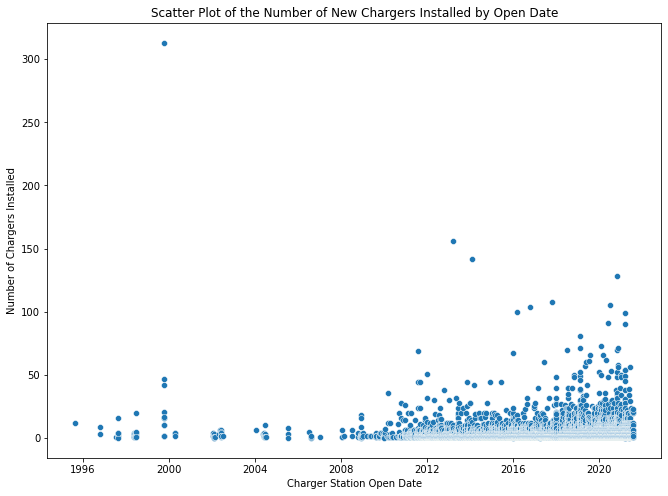

In [5]:
plt.figure(figsize=(11,8))
sns.scatterplot(x='open_date', y='total_chargers', data=ev)
plt.title('Scatter Plot of the Number of New Chargers Installed by Open Date')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Number of Chargers Installed')
plt.show()

##### Plot of EV Charging Station Locations
Below is a visual representation of the locations of all current EV Charging stations within the US based on their Lat/Long location.

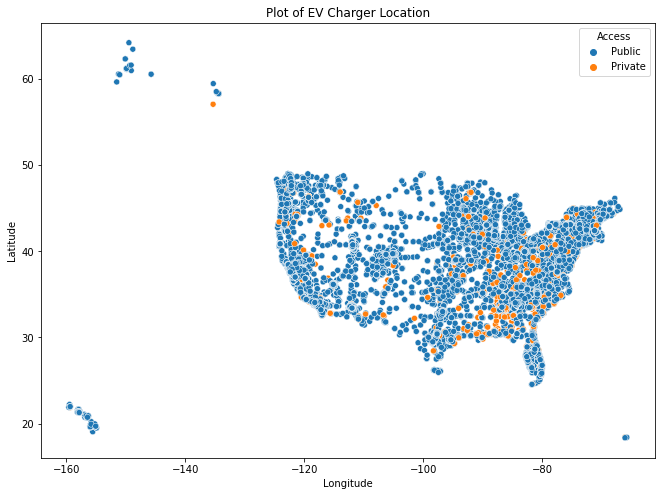

In [6]:
plt.figure(figsize=(11,8))
sns.scatterplot(x='long', y='lat',hue='group_access_code', data=ev)
plt.title('Plot of EV Charger Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Access')
plt.show()

##### Plot of the Cumulative Sum of EV Charging Stations over Time
The below graph shows the number of charging stations that have been built in the US over time.

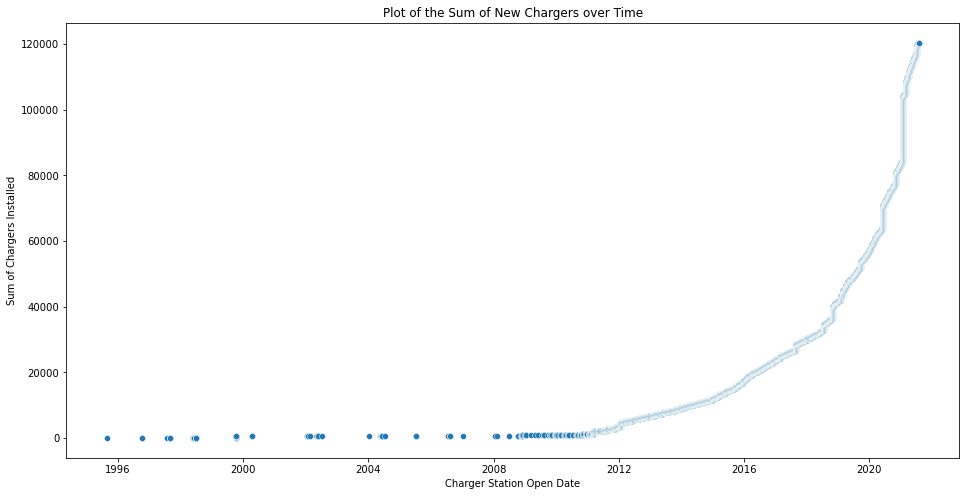

In [7]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='open_date', y='rolling_total_chargers', data=ev)
plt.title('Plot of the Sum of New Chargers over Time')
plt.xlabel('Charger Station Open Date')
plt.ylabel('Sum of Chargers Installed')
plt.show()

# 
***

## Exploration:
My goal is to predict the increase in charging stations 1-5 years into the future. Therefore, I reduced my dataframe to only include the open_date and total_chargers for the exploration phase. I also only included the data from 2010 and beyond since most of the charger production has occurred since then. 

In [8]:
ev = ev[['open_date', 'total_chargers']]

In [9]:
ev = ev.set_index('open_date')

In [10]:
ev = ev.resample('3M').sum()

In [11]:
# To include only the dates since 2010
ev = ev['2010':]

##### Train, Validate, Test Split

In [12]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(ev) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(ev) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(ev) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

# split into train, validation, test
train = ev[: train_size]
validate = ev[train_size : validate_end_index]
test = ev[validate_end_index : ]

In [13]:
# To see the split:
print('Train:', len(train), ' Validate:', len(validate), ' Test:', len(test))

Train: 23  Validate: 14  Test: 10


##### Plot of Train, Validate, and Test

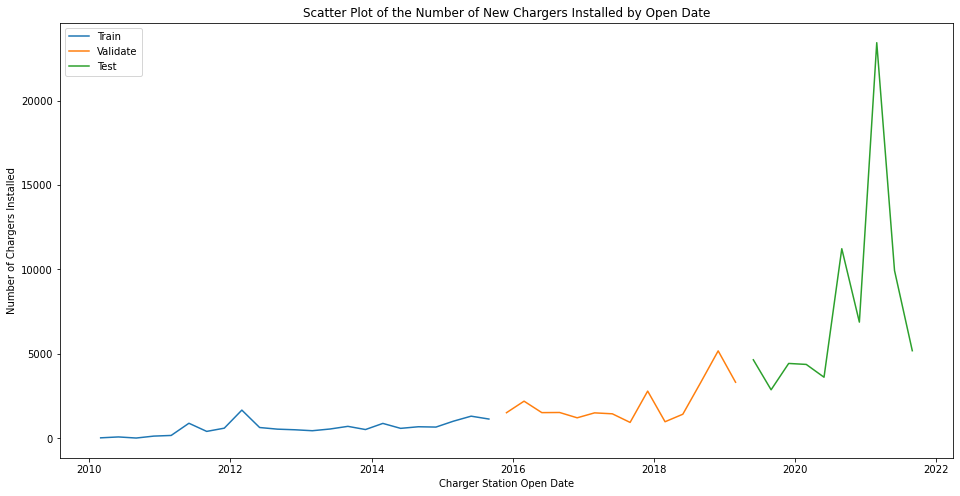

In [14]:
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='total_chargers', data=train)
sns.lineplot(x='open_date', y='total_chargers', data=validate)
sns.lineplot(x='open_date', y='total_chargers', data=test)
plt.title('Scatter Plot of the Number of New Chargers Installed by Open Date')
plt.legend(labels=['Train', 'Validate', 'Test'])
plt.xlabel('Charger Station Open Date')
plt.ylabel('Number of Chargers Installed')
plt.show()

##### Findings: 
Most of the EV charging stations within the US have been added since 2010 with an exponential increase over the last five years.
***
  

### Exploring Trends and Seasonal Decomposition within Train:
Below I used statsmodels' seasonal decomposition function to explore overall trends and seasonal components of the train dataset.
- 'y' is the data series that has been decomposed
- 'trend' is the trend component of the data series
- 'seasonal' is the seasonal component of the data series
- 'resid' is the residual component of the data series

In [15]:
y = train

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
open_date,,,,
2010-02-28,26.0,NaN,169.032813,NaN
2010-05-31,79.0,NaN,37.376563,NaN
2010-08-31,14.0,79.375,-81.517187,16.142187
2010-11-30,128.0,198.250,-124.892188,54.642188
2011-02-28,167.0,348.625,169.032813,-350.657812


##### Plot of Trends, seasonality, and the residual 

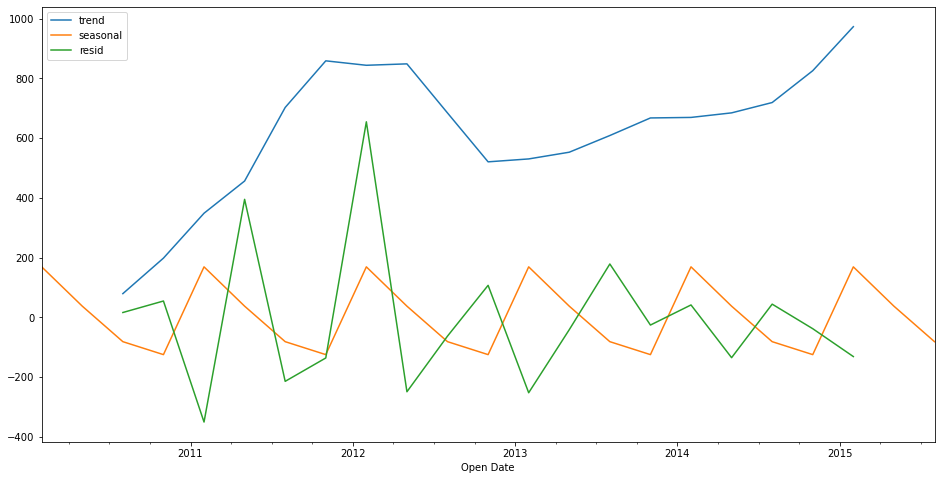

In [16]:
decomposition.iloc[:, 1:].plot(figsize=(16,8))
plt.xlabel('Open Date')
plt.show()

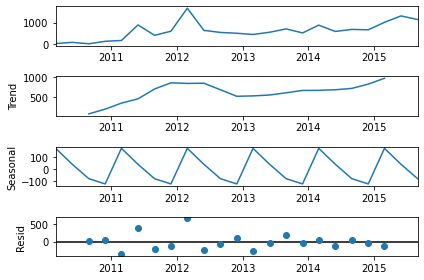

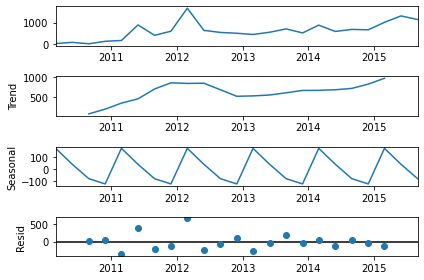

In [17]:
result.plot()

##### Findings: 
Overall, the trend increases sharply from 2010 to 2012 then decreases in 2013 before rising again through 2015 at the end of the train dataset. The seasonal decomposition function is indicating some seasonality dues to the fluctuation from 2011 to 2013 but the residual indicates a tapper of this after 2013. 
***

## Modeling:
Due to the upward trend of the dataset I chose to use the Holt model and the Holt-Winters Exponential Smoothing Model. The results are below.

### Holt Model:
Forecast equation:
y<sub>t+h|t</sub> = ℓ<sub>t</sub> + hb<sub>t</sub>

Level equation:
ℓ<sub>t</sub> = αy<sub>t</sub> + (1−α)(ℓ<sub>t−1</sub>+b<sub>t−1</sub>)

Trend equation:
b<sub>t</sub> = β<sup>∗</sup>(ℓ<sub>t</sub>−ℓ<sub>t−1</sub>) + (1−β<sup>∗</sup>)b<sub>t−1</sub>

t = open_date\
y = total_charges\
α = smoothing_slope\
β<sup>∗</sup> = smoothing_level



In [18]:
model = Holt(train['total_chargers'], exponential = False)
model = model.fit(smoothing_level = .8, 
                  smoothing_slope = .5, 
                  optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat = round(yhat_items, 2)

In [19]:
yhat = pd.DataFrame(yhat, columns=['total_chargers'])

##### Plot of the Holt Model Prediction vs the Validate Dataset

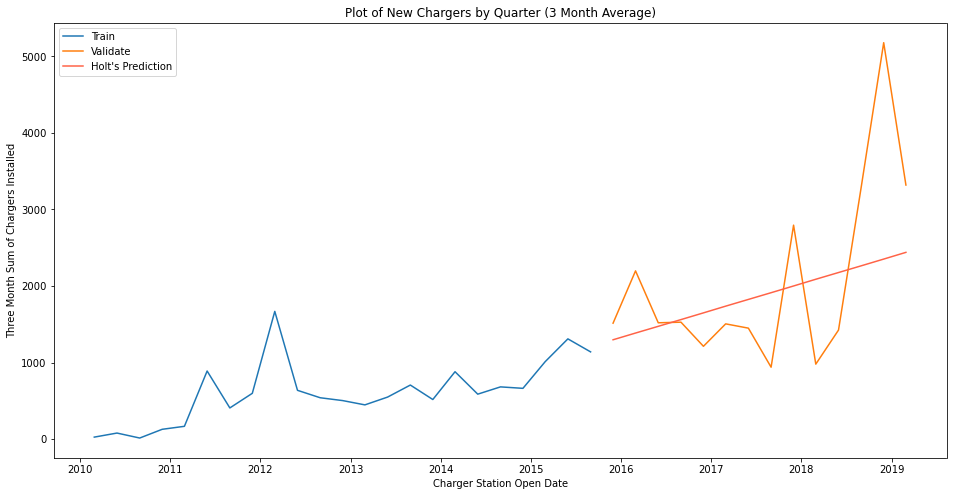

In [20]:
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='total_chargers', data=train)
sns.lineplot(x='open_date', y='total_chargers', data=validate)
sns.lineplot(x=yhat.index, y='total_chargers', data=yhat, color='tomato')

plt.title('Plot of New Chargers by Quarter (3 Month Average)')
plt.legend(labels=['Train', 'Validate', "Holt's Prediction"])
plt.xlabel('Charger Station Open Date')
plt.ylabel('Three Month Sum of Chargers Installed')
plt.show()

##### RMSE results of the Holt Model

In [21]:
eval_df = pd.DataFrame()
eval_df = md.append_eval_df(eval_df, 'Holt', 'Quarterly Sum of New Chargers', validate, yhat)
eval_df

,Model Type,Target Variable,RMSE
0,Holt,Quarterly Sum of New Chargers,1010.0


#### Results:
By adjusting the α = smoothing_slope = .5, and the β<sup>∗</sup> = smoothing_level = .8, I was able to acheive a RMSE of 1010.
***

### Holt-Winters Exponential Smoothing Model
The basic equations for Holt-Winters method are given by:

Overall Smoothing: S<sub>t</sub> = αy<sub>t</sub>/I<sub>t−L</sub> + (1−α)(S<sub>t−1</sub>+b<sub>t−1</sub>)  

Trend Smoothing: b<sub>t</sub> = γ(S<sub>t</sub>−S<sub>t−1</sub>) + (1−γ)b<sub>t−1</sub>  

Seasonal Smoothing: I<sub>t</sub> = βy<sub>t</sub>/S<sub>t</sub> + (1−β)I<sub>t−L</sub>  

Forecast: F<sub>t+m</sub> = (S<sub>t</sub> + mb<sub>t</sub>)I<sub>t−L+m</sub>  

Where:

- y is the observation
- S is the smoothed observation
- b is the trend factor
- I is the seasonal index
- F is the forecast at m periods ahead
- t is an index denoting a time period and α, β, and γ are constants that must be estimated in such a way that the MSE of the error is minimized. 

In [22]:
model = ExponentialSmoothing(train['total_chargers'], trend='mul')
model = model.fit(smoothing_level = 1, 
                  smoothing_slope = .5, 
                  optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat = round(yhat_items, 2)

In [23]:
yhat = pd.DataFrame(yhat, columns=['total_chargers'])

In [24]:
yhat.head()

,total_chargers
2015-11-30,1227.45
2016-02-29,1322.77
2016-05-31,1425.49
2016-08-31,1536.19
2016-11-30,1655.48


##### Plot of Holt-Winters Exponential Smoothing Model

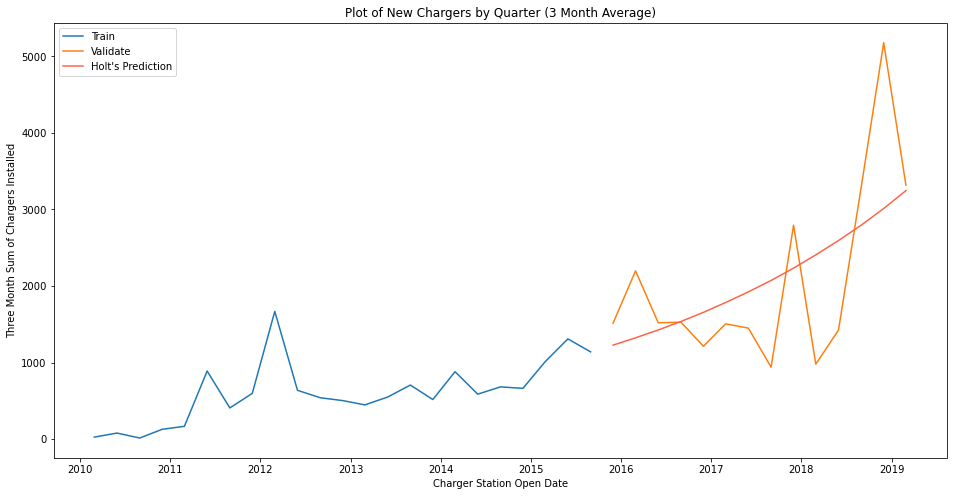

In [25]:
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='total_chargers', data=train)
sns.lineplot(x='open_date', y='total_chargers', data=validate)
sns.lineplot(x=yhat.index, y='total_chargers', data=yhat, color='tomato')

plt.title('Plot of New Chargers by Quarter (3 Month Average)')
plt.legend(labels=['Train', 'Validate', "Holt's Prediction"])
plt.xlabel('Charger Station Open Date')
plt.ylabel('Three Month Sum of Chargers Installed')
plt.show()

In [26]:
eval_df = md.append_eval_df(eval_df, 'Exp Smoothing', 'Quarterly Sum of New Chargers', validate, yhat)
eval_df

,Model Type,Target Variable,RMSE
0,Holt,Quarterly Sum of New Chargers,1010.0
1,Exp Smoothing,Quarterly Sum of New Chargers,898.0


#### Findings:
Overall the Holt-Winters Exponential Smoothing Model provided the best results with a RMSE of 898. This was achieved by adding a 'mul' (multiplier) trend to the model and a α = smoothing_slope = .5, and β<sup>∗</sup> = smoothing_level = 1. Therefore, I will use the Holt-Winters Exponential Smoothing Model on the test dataset and then predict beyond test (i.e. beyond 2021)
***

### Test

##### Resplitting the Data into Train and Test

In [27]:
# compute num of rows that are 80% of total rows and assign to variable train_size
train_size = int(len(ev) * .8)

# split into train and test
train = ev[: train_size]
test = ev[train_size : ]

In [28]:
# To see the split:
print('Train:', len(train), ' Test:', len(test))

Train: 37  Test: 10


#### Modeling using Holt-Winters Exponential Smoothing Model

In [29]:
model = ExponentialSmoothing(train['total_chargers'], trend='mul')
model = model.fit(smoothing_level = 1, 
                  smoothing_slope = .5, 
                  optimized = False)
yhat_items = model.predict(start = test.index[0], 
                           end = test.index[-1])
yhat = round(yhat_items, 2)

In [30]:
yhat = pd.DataFrame(yhat, columns=['total_chargers'])

##### Plot of Holt-Winters Exponential Smoothing Model

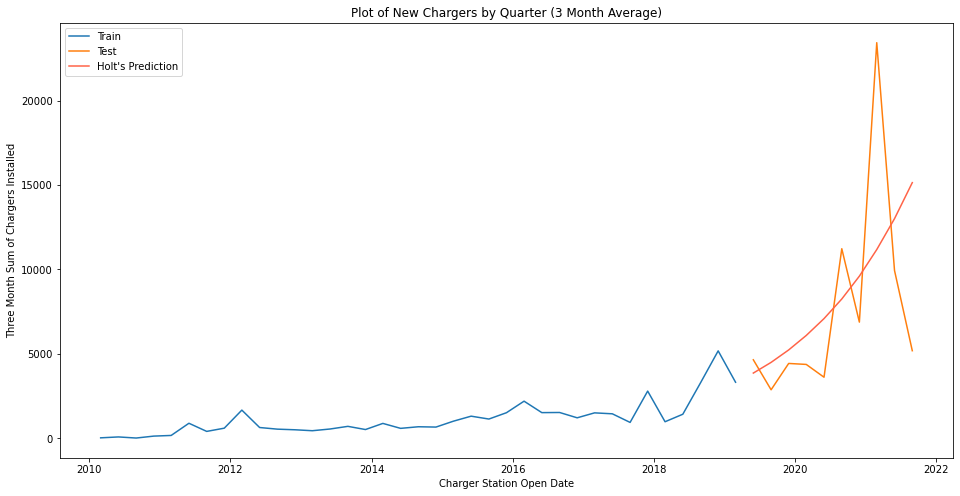

In [31]:
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='total_chargers', data=train)
sns.lineplot(x='open_date', y='total_chargers', data=test)
sns.lineplot(x=yhat.index, y='total_chargers', data=yhat, color='tomato')

plt.title('Plot of New Chargers by Quarter (3 Month Average)')
plt.legend(labels=['Train', 'Test', "Holt's Prediction"])
plt.xlabel('Charger Station Open Date')
plt.ylabel('Three Month Sum of Chargers Installed')
plt.show()

In [32]:
eval_df = pd.DataFrame()
eval_df = md.append_eval_df(eval_df, 'Exp Smoothing', 'Quarterly Sum of New Chargers', test, yhat)
eval_df

,Model Type,Target Variable,RMSE
0,Exp Smoothing,Quarterly Sum of New Chargers,5421.0


#### Results:
The RMSE was 5421 for the Holt-Winters Exponential Smoothing Model predictions verses the actual values from the test dataset. This increase is not surprising considering that the volume of new charging stations increases dramatically in the test data set over the train set. 
***

#### Examining the Results by Looking at the Cumulative Sum of Charging Stations Added
In order to explore the total growth of charging stations over time I combined the train and test datasets so that I could calculate the cumulative sum. I also combined yhat (the prediction dataset) with train so that I could calculate the cumulative sum for the prediction. I then plotted the result below to compare how they differ.

In [33]:
total_ev = pd.concat([train, test])
predict_ev = pd.concat([train, yhat])

In [34]:
total_ev['rolling_total_chargers'] = total_ev.total_chargers.cumsum()
predict_ev['rolling_total_chargers'] = predict_ev.total_chargers.cumsum()

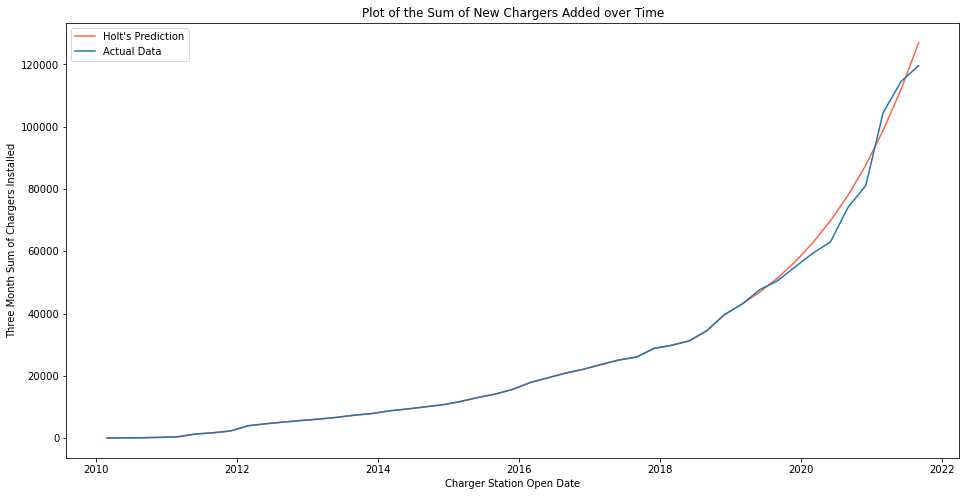

In [35]:
plt.figure(figsize=(16,8))
sns.lineplot(x=predict_ev.index, y='rolling_total_chargers', data=predict_ev, color='tomato')
sns.lineplot(x='open_date', y='rolling_total_chargers', data=total_ev)
plt.title('Plot of the Sum of New Chargers Added over Time')
plt.legend(labels=["Holt's Prediction", 'Actual Data'])
plt.xlabel('Charger Station Open Date')
plt.ylabel('Three Month Sum of Chargers Installed')
plt.show()

#### Results:
Exploring the results visually by looking at the cumulative sum of charging stations being added over time, the model does seem to be a fairly good predictor up until the end of the time period where the rate of increase for the actual data seem to decrease. 

### Next Steps: Predicting into the Future
For the final step I decided to predict two years into the future. Let's see how it looks.

In [36]:
# First I found the last date of the dataset
test.tail(1)

,total_chargers
open_date,
2021-08-31,5186


In [37]:
# Then I created a dataframe that started 3 months after the final date of our dataframe 
#(since 3M is the interval that we have been using) and continued that interval for two years:
future_ev = pd.DataFrame({'date': pd.date_range(datetime(2021,11,30), datetime(2023,11,30), freq='3M')})
future_ev = future_ev.set_index(future_ev.date)

#### Modeling using Holt-Winters Exponential Smoothing Model
This time using the same model but with the entire dataframe

In [38]:
model = ExponentialSmoothing(ev['total_chargers'], trend='mul')
model = model.fit(smoothing_level = 1, 
                  smoothing_slope = .5, 
                  optimized = False)
yhat_items = model.predict(start = future_ev.index[0], 
                           end = future_ev.index[-1])
yhat = round(yhat_items, 2)

In [39]:
yhat = pd.DataFrame(yhat, columns=['total_chargers'])

#### Plot of Holt-Winters Exponential Smoothing Model

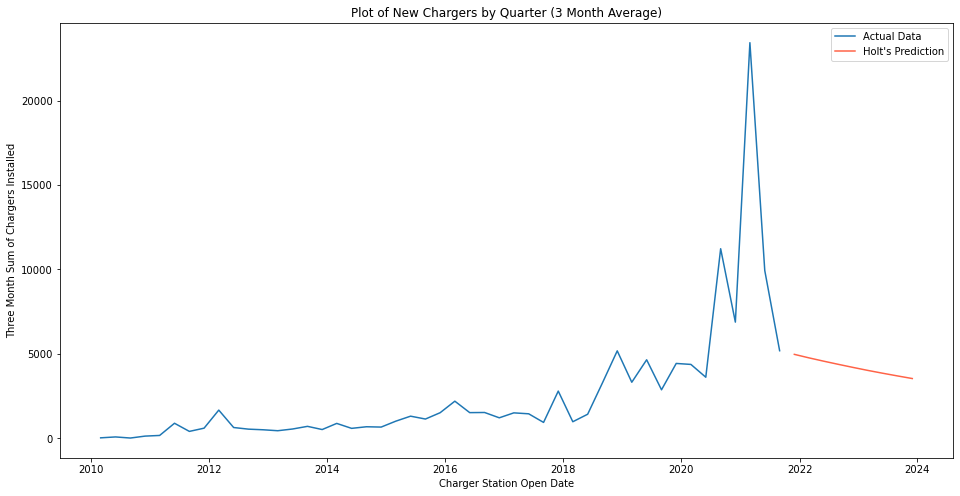

In [40]:
plt.figure(figsize=(16,8))
sns.lineplot(x='open_date', y='total_chargers', data=ev)
sns.lineplot(x=yhat.index, y='total_chargers', data=yhat, color='tomato')

plt.title('Plot of New Chargers by Quarter (3 Month Average)')
plt.legend(labels=['Actual Data', "Holt's Prediction"])
plt.xlabel('Charger Station Open Date')
plt.ylabel('Three Month Sum of Chargers Installed')
plt.show()

#### Findings:
The model accounts for the rate of change of new charging stations and tappers the growth expectations. A better visualization is to again examine the cumulative sum of the actual growth along with the prediction, which is below.

#### Examining the Results by Looking at the Cumulative Sum of Charging Stations Added

In [41]:
predict_ev = pd.concat([ev, yhat])

In [42]:
predict_ev['rolling_total_chargers'] = predict_ev.total_chargers.cumsum()

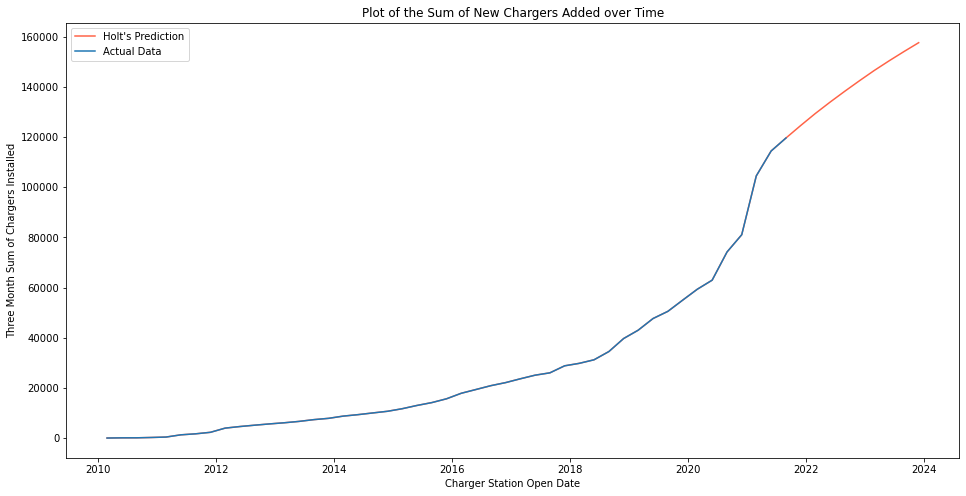

In [43]:
plt.figure(figsize=(16,8))
sns.lineplot(x=predict_ev.index, y='rolling_total_chargers', data=predict_ev, color='tomato')
sns.lineplot(x='open_date', y='rolling_total_chargers', data=total_ev)
plt.title('Plot of the Sum of New Chargers Added over Time')
plt.legend(labels=["Holt's Prediction", 'Actual Data'])
plt.xlabel('Charger Station Open Date')
plt.ylabel('Three Month Sum of Chargers Installed')
plt.show()

#### Findings:
The model smooths and tapers the exponential growth based on the slowed rate at the end of the dataset, which visually appears to be a reasonable prediction. So, what exactly is the prediction? See below!

### Final Prediction: 37,968 new EV Chargers over the next Two Years

In [44]:
round(predict_ev.rolling_total_chargers.max() - total_ev.rolling_total_chargers.max(), 0)

37968.0

Based on the past rate of adding new EV charging stations within the US, and utilizing the Holt-Winters Exponential Smoothing Model, we can forecast that approximately 37,968 new EV chargers will be added to the network over the next two years. Only time will tell if that prediction is accurate.
***

## Final Conclusion 
Predicting into the future can be tricky, and risky, business. Just because there was a trend in the past does not necessarily mean that a trend will continue into the future. In the case of Electric Vehicles, the technology behind these vehicles continues to change and progress on a regular basis. There are also environmental and political factors that heavily affect this business. Technology or legislation could be introduced at any time that would changes the rate of adding new charging stations to the US network. However, if the rate remains similar to the near past, then the Holt-Winters Exponential Smoothing Model proved to be a good predictor of future growth of EV chargers. The formula behind the model accounts for changes in rate of growth while not being overly sensitive to rapid changes in rate. It worked well for this situation, and I look forward to seeing how accurate the prediction becomes over time. 

#### Next Steps:
Going forward I would like to visually represent these findings on a dashboard using Tableau. I also plan to explore the other features of the dataset especially on pricing and public access to the charging stations. 